<a href="https://colab.research.google.com/github/Jguaquez/Red-LSTM-/blob/main/PROYECTO_PREDICCION_5_DIAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#SUBIR DATOS.
from google.colab import files
uploaded = files.upload()
#de esta manera tendremos que subir el archivo y evitamos consumop de gpu adicional.

Saving temp meteorologia.xlsx to temp meteorologia.xlsx


Este bloque de código carga los datos de dos hojas de un archivo Excel que contienen registros de temperatura tomados por dos sensores distintos ("Temp_DH" y "temperatura_LP"). Se define una función llamada clean_temperature que limpia y convierte los valores de temperatura, eliminando símbolos como "°C", reemplazando comas por puntos y convirtiendo los datos a tipo float. Luego, esta función se aplica a cada celda de ambas tablas con applymap. Posteriormente, se eliminan las filas y columnas que están completamente vacías y luego se eliminan las celdas individuales vacías para asegurar que los datos estén completamente limpios y listos para ser procesados por la red neuronal.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Cargar y limpiar
df_dh = pd.read_excel("temp meteorologia.xlsx", sheet_name="Temp_DH")
df_lp = pd.read_excel("temp meteorologia.xlsx", sheet_name="temperatura_LP")

def clean_temperature(value):
    if isinstance(value, str):
        value = value.replace("°C", "").replace(",", ".").strip()
    try:
        return float(value)
    except:
        return None

df_dh_clean = df_dh.applymap(clean_temperature)
df_lp_clean = df_lp.applymap(clean_temperature)

df_dh_clean.dropna(axis=0, how='all', inplace=True)
df_lp_clean.dropna(axis=0, how='all', inplace=True)
df_dh_clean.dropna(axis=1, how='all', inplace=True)
df_lp_clean.dropna(axis=1, how='all', inplace=True)
df_dh_clean.dropna(inplace=True)
df_lp_clean.dropna(inplace=True)



<ipython-input-14-6150adefcff6>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_dh_clean = df_dh.applymap(clean_temperature)
<ipython-input-14-6150adefcff6>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_lp_clean = df_lp.applymap(clean_temperature)


 convierte las columnas (que representan días) en filas, para que cada fila corresponda a un día de mediciones. Luego, reinicia los índices para mantener un orden limpio y secuencial. Como puede haber una diferencia en el número de días registrados entre ambos sensores, se ajusta el tamaño de ambos DataFrames al del más corto (min_len), eliminando los días sobrantes en caso de que uno tenga más filas que el otro. Esto garantiza que ambas fuentes de datos estén alineadas correctamente para poder combinarlas o procesarlas juntas más adelante.

In [ ]:
# Transposición para tener días como filas
df_dh_clean = df_dh_clean.T.reset_index(drop=True)
df_lp_clean = df_lp_clean.T.reset_index(drop=True)

# Igualar número de filas
min_len = min(len(df_dh_clean), len(df_lp_clean))
df_dh_clean = df_dh_clean.iloc[:min_len]
df_lp_clean = df_lp_clean.iloc[:min_len]


ESTA ES UNA RED NEURONAL LSTM
unimos los datos de ambos sensores (df_dh_clean y df_lp_clean) en un solo DataFrame, colocando las columnas de un sensor junto a las del otro. Luego, normaliza todos los valores al rango [0, 1] usando MinMaxScaler, lo cual es importante para mejorar el rendimiento y estabilidad del entrenamiento de la red neuronal. A continuación, se define una función create_sequences que crea secuencias de datos temporales: toma una ventana de timesteps días consecutivos como entrada (X) y los valores de los siguientes days_ahead días como objetivo de predicción (y). Finalmente, esta función se llama con una ventana de 3 días y un horizonte de predicción de 5 días, generando los arreglos X y y necesarios para entrenar la red neuronal LSTM.

Una LSTM (Long Short-Term Memory) es un tipo especial de red neuronal recurrente (RNN) diseñada para trabajar con secuencias de datos, como series temporales, texto o audio. A diferencia de una RNN simple, una LSTM puede recordar información importante durante periodos largos de tiempo y olvidar información irrelevante, gracias a una estructura interna basada en "puertas" (de entrada, olvido y salida).

Ideal para Predecir datos futuros basados en datos pasados (como temperaturas, precios, señales, etc.).

In [ ]:
#Unir y normalizar
data = pd.concat([df_dh_clean, df_lp_clean], axis=1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#crear ventanas para LSTM
def create_sequences(data, timesteps=3, days_ahead=5):
    X, y = [], []
    for i in range(len(data) - timesteps - days_ahead + 1):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps:i+timesteps+days_ahead])
    return np.array(X), np.array(y)

timesteps = 3
days_ahead = 5
X, y = create_sequences(data_scaled, timesteps, days_ahead)


Este código construye y entrena una red neuronal LSTM para predecir temperaturas futuras basadas en datos pasados

n_features: cantidad de variables por tiempo (en tu caso, 2 sensores de temperatura).

LSTM(64, ...): capa LSTM con 64 neuronas, que aprende patrones en secuencias de 3 días.

input_shape=(timesteps, n_features): el modelo espera secuencias de 3 pasos (días), cada uno con 2 variables.

Dense(...): capa final que entrega una predicción para los próximos days_ahead días (5), con una predicción por cada variable (5 × 2 = 10 valores en total).

Se usa el optimizador Adam, muy efectivo para la mayoría de tareas.

La pérdida es MSE (error cuadrático medio), adecuada para predicción de valores numéricos continuos como temperatura.

In [ ]:
#Modelo LSTM
n_features = X.shape[2]
model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, n_features)),
    Dense(days_ahead * n_features)
])
model.compile(optimizer='adam', loss='mse')

#Entrenar
model.fit(X, y.reshape((y.shape[0], days_ahead * n_features)), epochs=100, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ealiza la predicción de los próximos 5 días usando el modelo LSTM ya entrenado, y luego desnormaliza y muestra los resultados de forma clara

data_scaled[-timesteps:]: toma los últimos 3 días como ventana de entrada para predecir lo que sigue.

reshape(...): ajusta la forma de los datos para que coincida con lo que espera la red (1 muestra, 3 días, 2 variables).

model.predict(...): realiza la predicción.

reshape(...): acomoda la predicción en forma de matriz con 5 filas (1 por día) y 2 columnas (una por variable: df_dh y df_lp).

In [ ]:
#Predicción
last_window = data_scaled[-timesteps:].reshape((1, timesteps, n_features))
prediction_scaled = model.predict(last_window)
prediction_scaled = prediction_scaled.reshape((days_ahead, n_features))

#Desnormalizar predicción
predicted_future = scaler.inverse_transform(prediction_scaled)

# Mostrar predicción

columnas = [f"df_dh_dia{i+1}" for i in range(days_ahead)] + [f"df_lp_dia{i+1}" for i in range(days_ahead)]
predicted_df = pd.DataFrame(predicted_future, columns=columnas)
print("Predicción para los próximos 5 días (una columna por día y variable):")
print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicción para los próximos 5 días (una columna por día y variable):
   df_dh_dia1  df_dh_dia2  df_dh_dia3  df_dh_dia4  df_dh_dia5  df_lp_dia1  \
0   19.135683   20.091578   19.334305   20.670439   20.590061   19.697374   
1   20.365551   20.940613   19.909388   21.018902   19.851519   19.707060   
2   20.614370   21.315275   19.467131   19.767076   19.647020   18.882977   
3   19.487207   20.327808   18.791800   20.508232   18.657995   18.996984   
4   19.931561   21.656881   19.631451   20.596357   18.777353   18.642220   

   df_lp_dia2  df_lp_dia3  df_lp_dia4  df_lp_dia5  
0   18.095028   21.415497   21.067131   21.758369  
1   17.615843   21.032711   21.099789   20.806044  
2   19.068428   20.976513   20.964951   21.769884  
3   17.579824   20.204899   20.514797   20.092041  
4   18.459618   21.456203   20.200924   21.054218  


CODIGO PARA MOSTRAR GRAFICAS

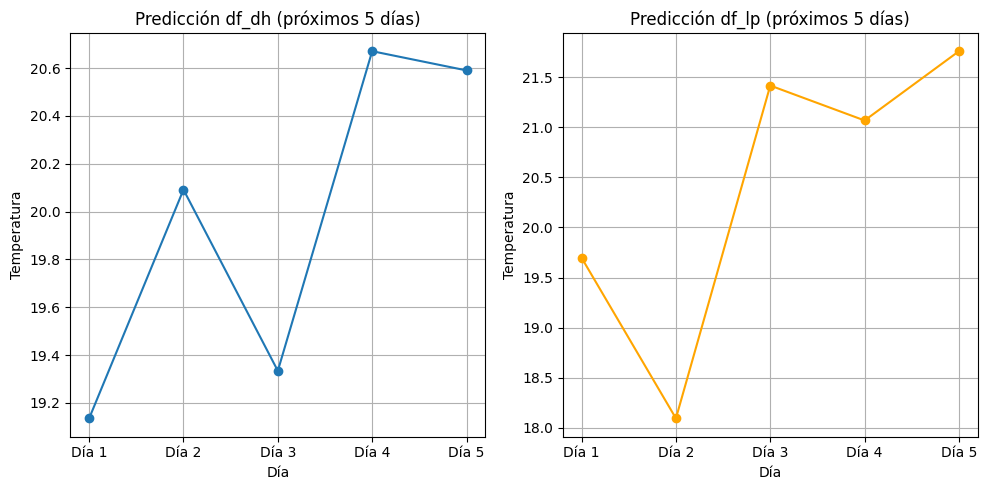

In [ ]:
import matplotlib.pyplot as plt

# Separar las columnas por variable
df_dh_pred = predicted_df[[col for col in predicted_df.columns if "df_dh" in col]].iloc[0].values
df_lp_pred = predicted_df[[col for col in predicted_df.columns if "df_lp" in col]].iloc[0].values

dias = [f"Día {i+1}" for i in range(days_ahead)]

# Crear gráfico
plt.figure(figsize=(10, 5))

# Plot df_dh
plt.subplot(1, 2, 1)
plt.plot(dias, df_dh_pred, marker='o')
plt.title("Predicción df_dh (próximos 5 días)")
plt.xlabel("Día")
plt.ylabel("Temperatura")
plt.grid(True)

# Plot df_lp
plt.subplot(1, 2, 2)
plt.plot(dias, df_lp_pred, marker='o', color='orange')
plt.title("Predicción df_lp (próximos 5 días)")
plt.xlabel("Día")
plt.ylabel("Temperatura")
plt.grid(True)

plt.tight_layout()
plt.show()

